In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from collections import Counter, defaultdict
import xgboost as xgb
import lightgbm as lgb

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.preprocessing import StandardScaler, Imputer, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor

C:\Users\CSH\Anaconda3\lib\site-packages\pandas\tseries\tools.py:5: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  import pandas.lib as lib
C:\Users\CSH\Anaconda3\lib\site-packages\pandas\tseries\tools.py:6: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  import pandas.tslib as tslib
C:\Users\CSH\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\CSH\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\CSH

In [2]:
sns.set_style('darkgrid')
pd.set_option('display.max_columns', 500)

In [5]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [6]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [8]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [82]:
test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


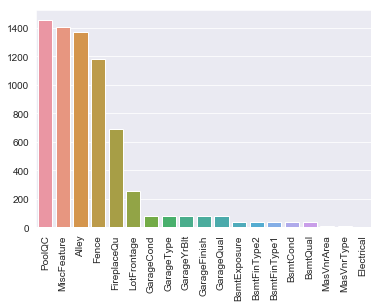

In [9]:
# # Checking # of NA 
# tmp = pd.isnull(train).sum()
# for i in range(len(tmp)):
#     if tmp[i] != 0:
#         print('%s %s %d %s (%.2f%s)'%(tmp.index[i],' '*(20-len(tmp.index[i])), 
#                                   tmp[i], ' '*(6 - len(str(tmp[i]))), 
#                                   tmp[i]/len(train)*100, '%'))
        
# Checking NA's
tmp = pd.isnull(train).sum()
tmp = tmp.sort_values(ascending=False)
tmp = tmp[tmp>0]
plt.xticks(rotation=90)
sns.barplot(x=tmp.index, y=tmp)
plt.show()

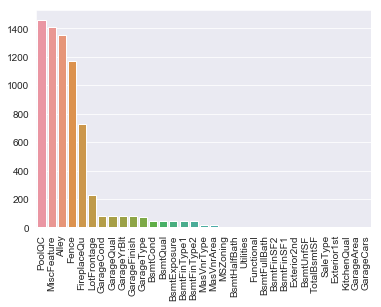

In [10]:
tmp = pd.isnull(test).sum()
tmp = tmp.sort_values(ascending=False)
tmp = tmp[tmp>0]
plt.xticks(rotation=90)
sns.barplot(x=tmp.index, y=tmp)
plt.show()

In [11]:
# Categorizing variables 
num_col = []
cat_col = []

for column in train.columns[~pd.Series(train.columns).isin(['Id', 'SalePrice'])]:
    if type(train[column][0]) is not str:
        num_col.append(column)
    else:
        cat_col.append(column)

tmp = ['MSSubClass', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold'] # Handwork ! 
num_col = list(set(num_col) - set(tmp))
cat_col += tmp

for col in tmp:
    train[col] = train[col].astype(str)

### Target Variable

Before >  Mean: 180921.195890, Standard Deviation: 79415.291886


C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


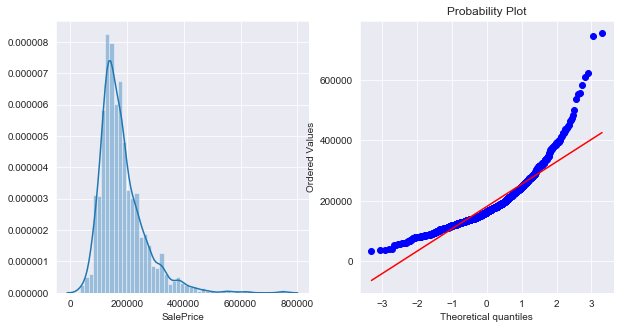

In [12]:
# skew and log transformation for the target variable
fig, ax= plt.subplots(1,2, figsize = (10,5))
print("Before >  Mean: %f, Standard Deviation: %f" %norm.fit(train['SalePrice']))
sns.distplot(train['SalePrice'], ax = ax[0])
stats.probplot(train['SalePrice'], plot=ax[1])
plt.show()

After > Mean: 12.024057, Standard Deviation: 0.399312


C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


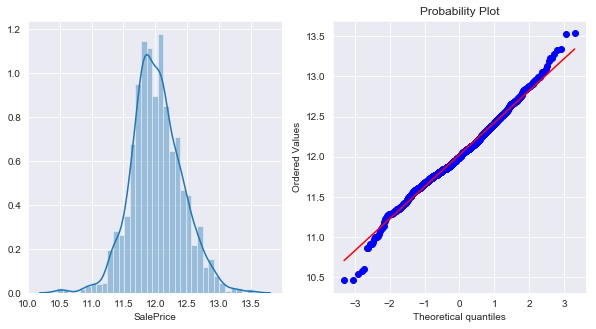

In [13]:
# after log transformation to the target var
fig, ax= plt.subplots(1,2, figsize = (10,5))
tmp = np.log1p(train['SalePrice']) # log(1+x)
print("After > Mean: %f, Standard Deviation: %f" %norm.fit(tmp))
sns.distplot(tmp, ax = ax[0])
stats.probplot(tmp, plot=ax[1])
plt.show()

In [16]:
# vars' corr with the target var
col_corr = []
for col in num_col:
    na_idx = pd.isnull(train[col])
    corr = np.corrcoef(x= train[col][~na_idx], y=train['SalePrice'][~na_idx])[0,1]
    col_corr.append((col, corr))
col_corr.sort(key=lambda x : -abs(x[1]))

col_corr

[('OverallQual', 0.7909816005838052),
 ('GrLivArea', 0.7086244776126521),
 ('GarageCars', 0.6404091972583522),
 ('GarageArea', 0.6234314389183616),
 ('TotalBsmtSF', 0.6135805515591954),
 ('1stFlrSF', 0.6058521846919145),
 ('FullBath', 0.5606637627484456),
 ('TotRmsAbvGrd', 0.5337231555820281),
 ('YearBuilt', 0.5228973328794968),
 ('YearRemodAdd', 0.5071009671113862),
 ('GarageYrBlt', 0.48636167748786086),
 ('MasVnrArea', 0.4774930470957155),
 ('Fireplaces', 0.46692883675152796),
 ('BsmtFinSF1', 0.3864198062421531),
 ('LotFrontage', 0.351799096570678),
 ('WoodDeckSF', 0.3244134445681296),
 ('2ndFlrSF', 0.3193338028320677),
 ('OpenPorchSF', 0.3158562271160552),
 ('HalfBath', 0.2841076755947825),
 ('LotArea', 0.2638433538714056),
 ('BsmtFullBath', 0.22712223313149438),
 ('BsmtUnfSF', 0.2144791055469689),
 ('BedroomAbvGr', 0.16821315430074002),
 ('KitchenAbvGr', -0.1359073708421411),
 ('EnclosedPorch', -0.12857795792595658),
 ('ScreenPorch', 0.11144657114291115),
 ('PoolArea', 0.0924035494

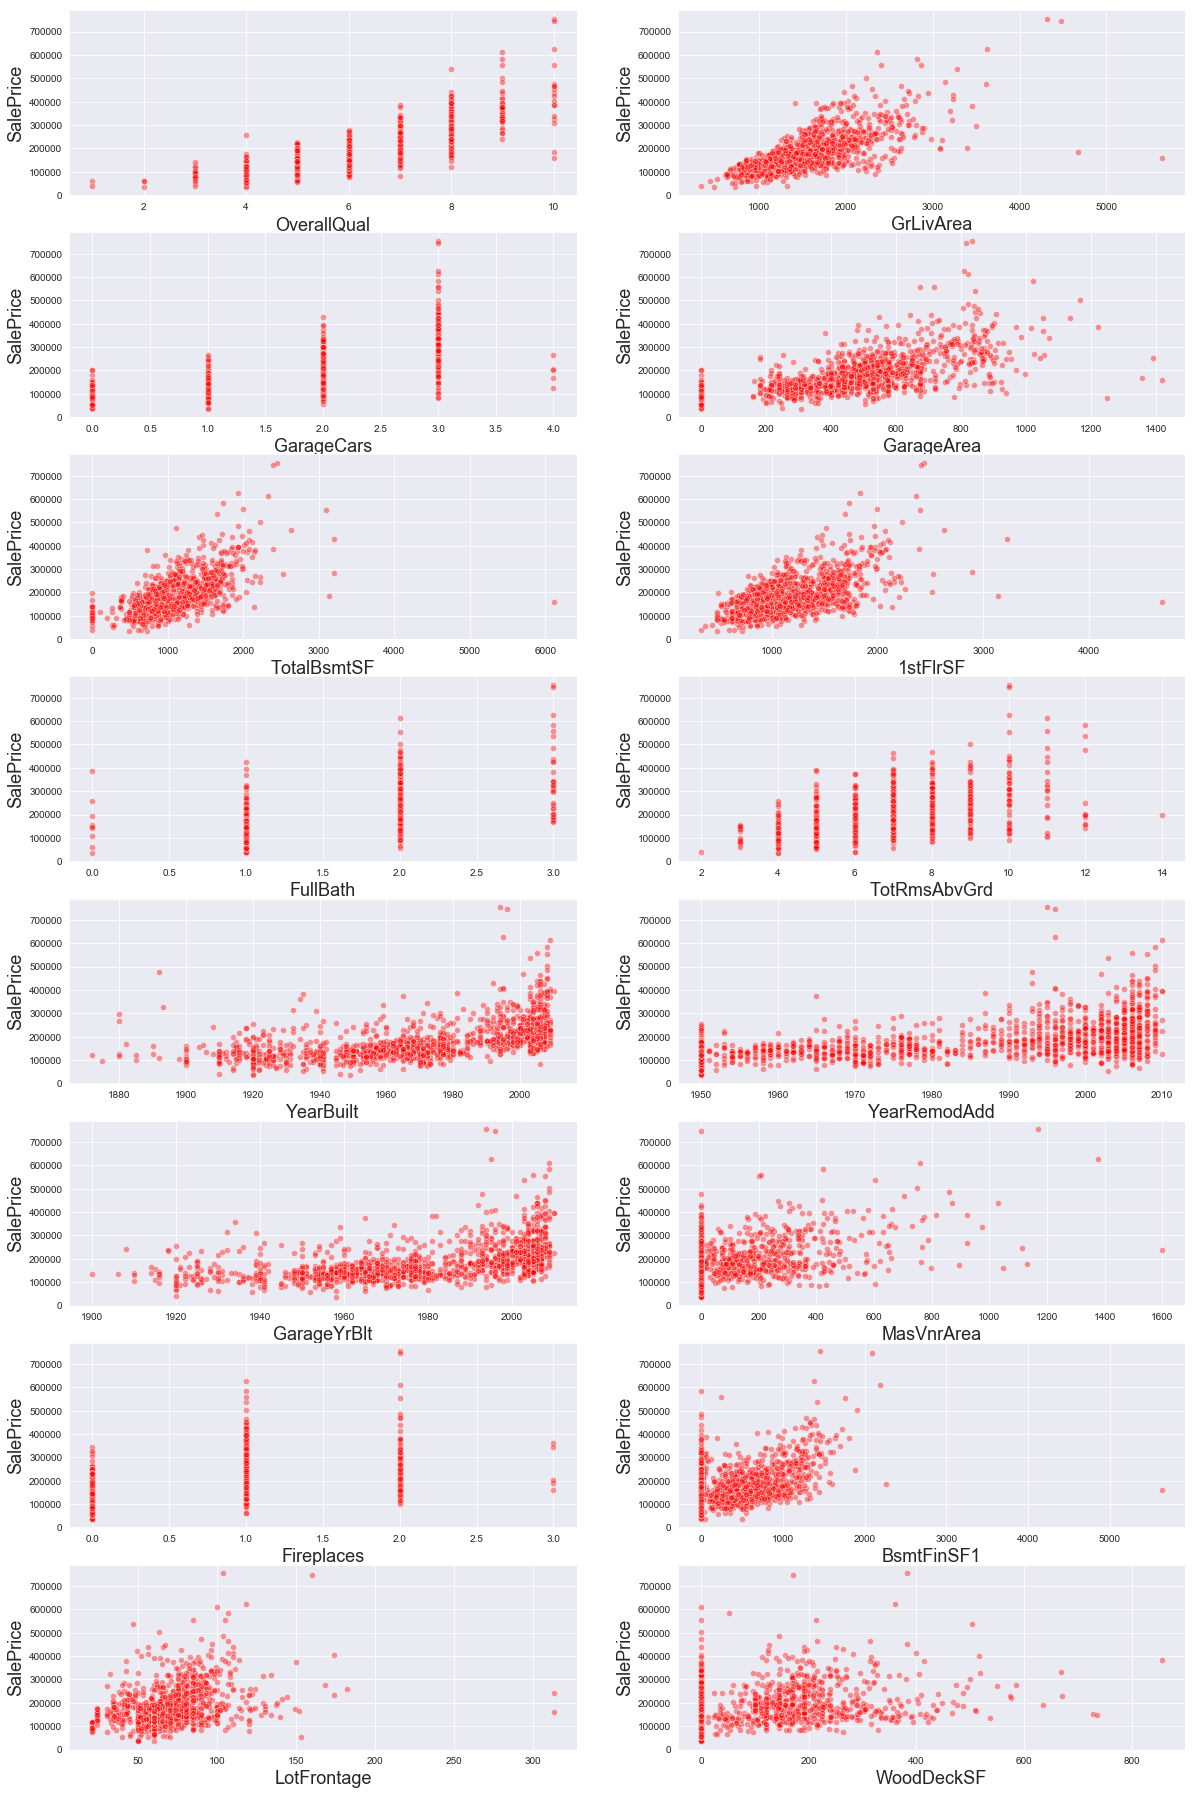

In [17]:
# Top N's scatter plots
N=16
top_N_num = [set[0] for set in col_corr[:N]]

fig, ax = plt.subplots(int(np.ceil(N/2)),2, figsize=(20,N*2))
for i, col in enumerate(top_N_num):
    sns.scatterplot(data=train, 
             x=col, 
             y="SalePrice", 
             alpha=0.4, 
             color='red',
             ax=ax[i//2][i%2])
    ax[i//2][i%2].set_xlabel(col, fontsize=18)
    ax[i//2][i%2].set_ylabel('SalePrice', fontsize=18)
plt.show()

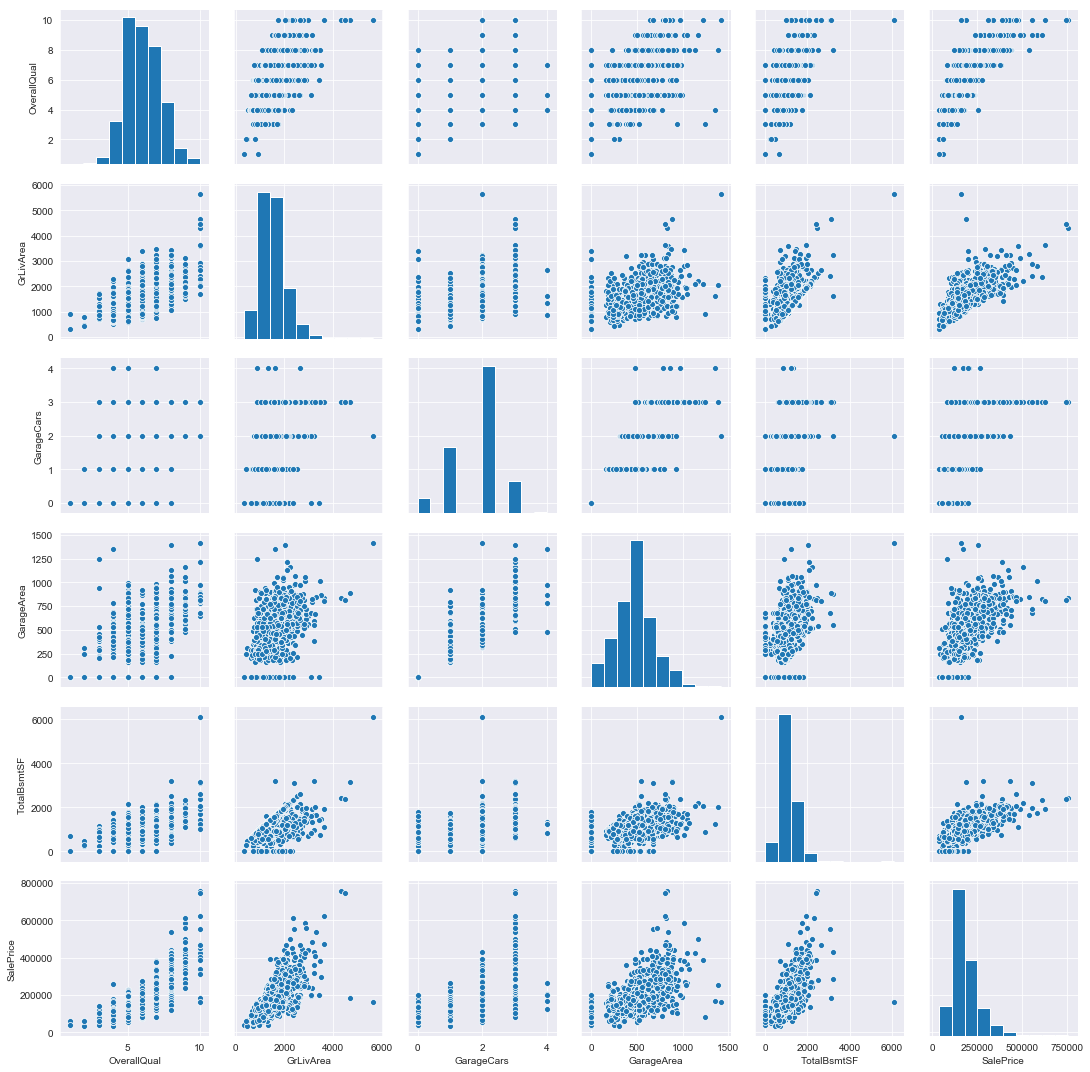

In [18]:
# pairplot: top 5 highest correlated vars and target var
N=5
top_N_num = [set[0] for set in col_corr[:N]]
top_N_num.append('SalePrice')

plt.figure(figsize=(10,8))
sns.pairplot(train[top_N_num])
plt.show()

In [19]:
# top N's lowest P-value variables
col_aov = []
for col in cat_col:
    result = ols('SalePrice ~ {}'.format(col), data = train).fit()
    aov_table = sm.stats.anova_lm(result)
    aov_pr = aov_table['PR(>F)'][0]
    col_aov.append((col, aov_pr))

col_aov.sort(key = lambda x: x[1]) # ascending order of p-value 

col_aov

C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


[('Neighborhood', 1.5586002827707996e-225),
 ('ExterQual', 1.4395510967805077e-204),
 ('KitchenQual', 3.0322127528354076e-192),
 ('BsmtQual', 9.610615106776792e-186),
 ('GarageFinish', 1.19911653122929e-93),
 ('Foundation', 5.791895002230916e-91),
 ('MSSubClass', 8.66216626609302e-79),
 ('HeatingQC', 2.6670620921029927e-67),
 ('GarageType', 1.247153670659079e-66),
 ('MasVnrType', 4.793331178119194e-65),
 ('BsmtFinType1', 1.8077310066865764e-63),
 ('SaleCondition', 7.98826840498743e-44),
 ('Exterior1st', 2.586088728638036e-43),
 ('Exterior2nd', 4.8421856706967575e-43),
 ('BsmtExposure', 1.0226706291840408e-42),
 ('SaleType', 5.0397668894614484e-42),
 ('MSZoning', 8.817633866271897e-35),
 ('HouseStyle', 3.376776535121486e-25),
 ('LotShape', 6.447523852011766e-25),
 ('CentralAir', 1.8095061559272612e-22),
 ('FireplaceQu', 5.016300447019336e-19),
 ('Electrical', 1.6632487814733502e-18),
 ('PavedDrive', 1.8035688906523017e-18),
 ('RoofStyle', 3.653523047100008e-17),
 ('BldgType', 2.05673646

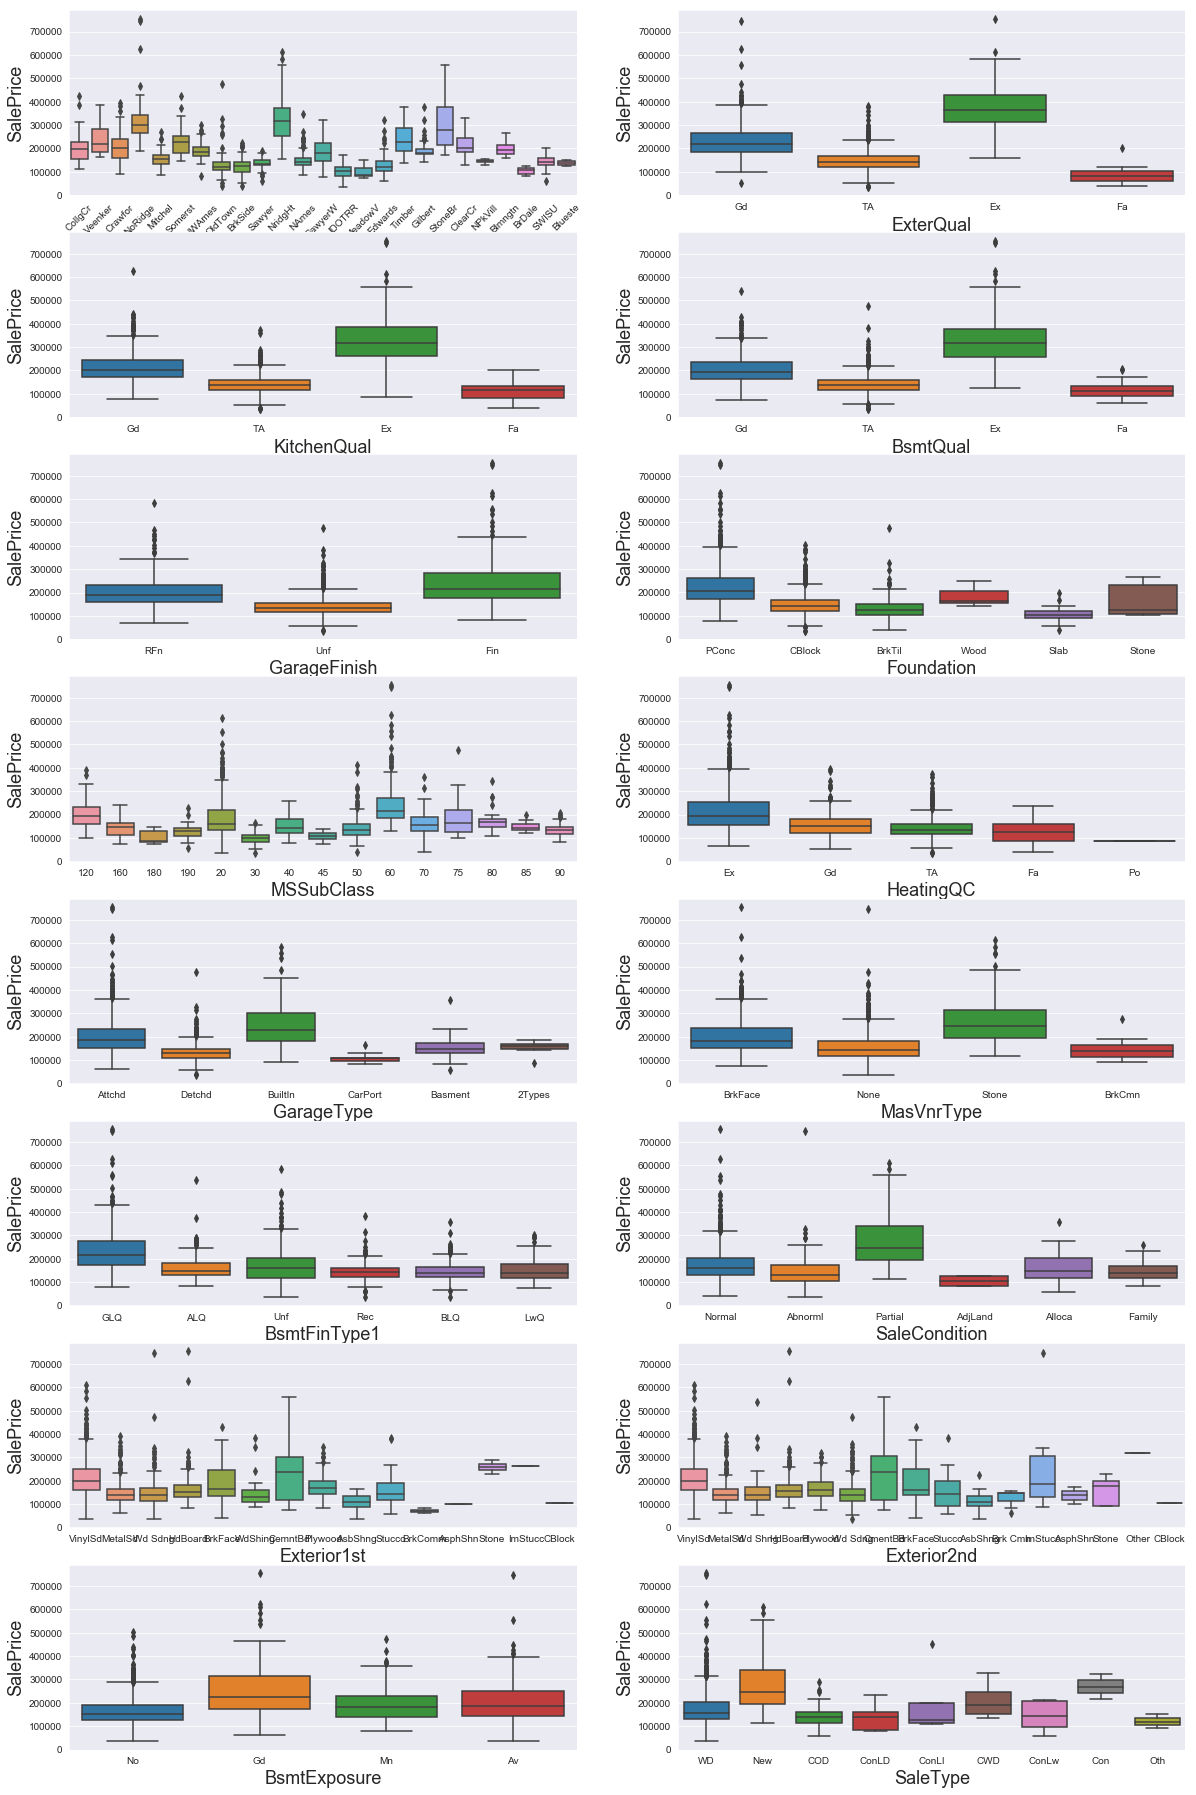

In [20]:
# Box plot of Top N Categorical Vars
N= 16
top_N_num = [set[0] for set in col_aov[:N]]

fig, ax = plt.subplots(int(np.ceil(N/2)),2, figsize=(20,N*2))
plt.setp(ax[0][0].get_xticklabels(), rotation=45)
for i, col in enumerate(top_N_num):
    sns.boxplot(x=col, y='SalePrice', data=train, ax=ax[i//2][i%2])
    ax[i//2][i%2].set_xlabel(col, fontsize=18)
    ax[i//2][i%2].set_ylabel('SalePrice', fontsize=18)
plt.show()

### Independant Variables

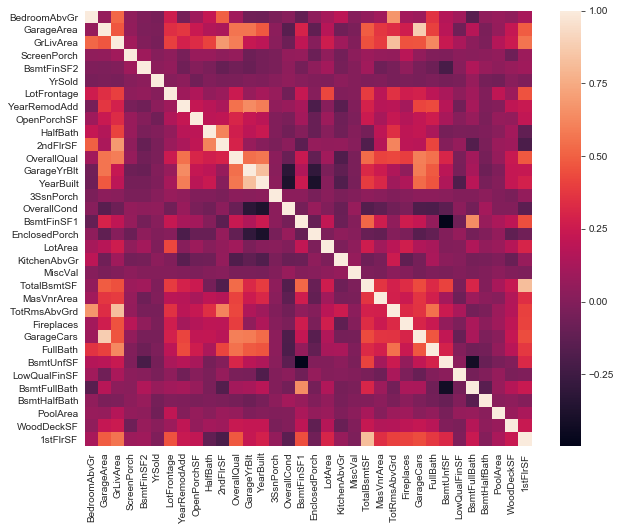

In [21]:
# Corr matrix (Train data)
plt.figure(figsize=(10,8))
corr_table = train[num_col].corr()
sns.heatmap(corr_table)
plt.show()

In [22]:
# N highest corr pairs  (Train data)
high_cor_list = []
tmp = corr_table[abs(corr_table)>0.4]
for col in tmp.columns:
    for row in tmp[col][~pd.isnull(tmp[col])].index:
        if col == row:
            break
        high_cor_list.append((col,row, tmp[col][row]))
high_cor_list.sort(key = lambda x : -x[2])
high_cor_list

[('GarageCars', 'GarageArea', 0.8824754142814603),
 ('YearBuilt', 'GarageYrBlt', 0.8256674841743434),
 ('TotRmsAbvGrd', 'GrLivArea', 0.8254893743088377),
 ('1stFlrSF', 'TotalBsmtSF', 0.8195299750050355),
 ('2ndFlrSF', 'GrLivArea', 0.6875010641666008),
 ('TotRmsAbvGrd', 'BedroomAbvGr', 0.6766199357426479),
 ('BsmtFullBath', 'BsmtFinSF1', 0.6492117535742737),
 ('GarageYrBlt', 'YearRemodAdd', 0.6422767797035414),
 ('FullBath', 'GrLivArea', 0.6300116462511144),
 ('TotRmsAbvGrd', '2ndFlrSF', 0.6164226354915353),
 ('2ndFlrSF', 'HalfBath', 0.6097073002717444),
 ('GarageCars', 'OverallQual', 0.6006707165907189),
 ('OverallQual', 'GrLivArea', 0.5930074300286511),
 ('YearBuilt', 'YearRemodAdd', 0.5928549763436497),
 ('GarageCars', 'GarageYrBlt', 0.5889200070047019),
 ('YearBuilt', 'OverallQual', 0.572322768962362),
 ('1stFlrSF', 'GrLivArea', 0.5660239689357487),
 ('GarageYrBlt', 'GarageArea', 0.5645670607230588),
 ('OverallQual', 'GarageArea', 0.5620217566126064),
 ('FullBath', 'TotRmsAbvGrd', 0

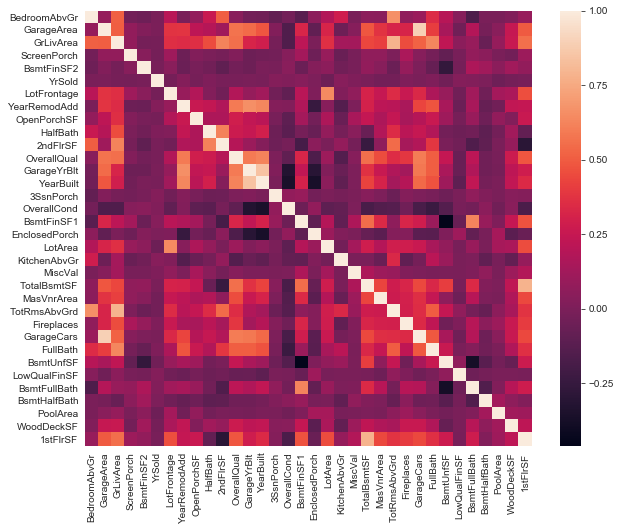

In [23]:
# Correlation Matrix  (Test data)
plt.figure(figsize=(10,8))
corr_table = test[num_col].corr()
sns.heatmap(corr_table)
plt.show()

In [24]:
# N highest corr pairs (Test data)
high_cor_list = []
tmp = corr_table[abs(corr_table)>0.4]
for col in tmp.columns:
    for row in tmp[col][~pd.isnull(tmp[col])].index:
        if col == row:
            break
        high_cor_list.append((col,row, tmp[col][row]))
high_cor_list.sort(key = lambda x : -x[2])
high_cor_list

[('GarageCars', 'GarageArea', 0.8966742862610428),
 ('YearBuilt', 'GarageYrBlt', 0.844149997399582),
 ('TotRmsAbvGrd', 'GrLivArea', 0.7880121098626653),
 ('1stFlrSF', 'TotalBsmtSF', 0.7845378852955079),
 ('TotRmsAbvGrd', 'BedroomAbvGr', 0.664498074042977),
 ('GarageYrBlt', 'YearRemodAdd', 0.6617646963260193),
 ('LotArea', 'LotFrontage', 0.6446084977757542),
 ('FullBath', 'GrLivArea', 0.6327005722230237),
 ('YearBuilt', 'YearRemodAdd', 0.6316957828685246),
 ('BsmtFullBath', 'BsmtFinSF1', 0.6289032695674641),
 ('YearBuilt', 'OverallQual', 0.6219102996941227),
 ('2ndFlrSF', 'GrLivArea', 0.6184461943301933),
 ('2ndFlrSF', 'HalfBath', 0.6134301103164588),
 ('GarageCars', 'OverallQual', 0.6008312111349207),
 ('GarageYrBlt', 'OverallQual', 0.5930802267410445),
 ('OverallQual', 'YearRemodAdd', 0.5912666710950133),
 ('GarageCars', 'GarageYrBlt', 0.5866488350943226),
 ('OverallQual', 'GarageArea', 0.5681607252557583),
 ('1stFlrSF', 'GrLivArea', 0.5606305009540099),
 ('TotalBsmtSF', 'OverallQual'

### Outlier

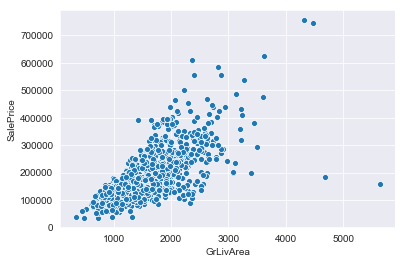

In [25]:
# outlier found in the above graph
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice') 
plt.show() # 2 ourliers at the bottom right

In [26]:
# outlier checking with univariate anlaysis
scaler = StandardScaler()
tmp = scaler.fit_transform(train[['SalePrice']])
tmp_sorted = sorted(np.squeeze(tmp))
for a, b in zip(tmp_sorted[:10], tmp_sorted[-10:]):
    print('{} {} {}' .format(round(a, 5), ' '*10, round(b,5)))

-1.8387            3.82897
-1.83353            4.04098
-1.80093            4.49635
-1.7833            4.71041
-1.77448            4.73032
-1.62338            5.06215
-1.61708            5.42384
-1.5856            5.59186
-1.5856            7.1029
-1.5731            7.22882


In [27]:
train[tmp>7] # Be careful of them! 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,nan,nan,nan,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,nan,0,7,2007,WD,Abnorml,745000


### Checking Skew Problem

In [28]:
skews = []
for col in num_col:
    skews.append((col, skew(train[col])))
skews.sort(key=lambda x : -abs(x[1]))
skews

[('MiscVal', 24.4516396173223),
 ('PoolArea', 14.813134660429398),
 ('LotArea', 12.195142125084478),
 ('3SsnPorch', 10.293752357165413),
 ('LowQualFinSF', 9.002080417658552),
 ('KitchenAbvGr', 4.483784093860484),
 ('BsmtFinSF2', 4.250888017057445),
 ('ScreenPorch', 4.1179773827954875),
 ('BsmtHalfBath', 4.0991856695420035),
 ('EnclosedPorch', 3.086696471376678),
 ('OpenPorchSF', 2.361911928568972),
 ('BsmtFinSF1', 1.6837708962341815),
 ('WoodDeckSF', 1.5397916998042025),
 ('TotalBsmtSF', 1.522688086978629),
 ('1stFlrSF', 1.3753417421837937),
 ('GrLivArea', 1.365155954773434),
 ('BsmtUnfSF', 0.9193227015582005),
 ('2ndFlrSF', 0.8121942731961613),
 ('OverallCond', 0.6923552135520978),
 ('TotRmsAbvGrd', 0.6756457673102017),
 ('HalfBath', 0.6752028347742616),
 ('Fireplaces', 0.6488976310170327),
 ('YearBuilt', -0.612830724202899),
 ('BsmtFullBath', 0.5954540376067279),
 ('YearRemodAdd', -0.5030444967597948),
 ('GarageCars', -0.34219689543081294),
 ('OverallQual', 0.2167209765258641),
 ('Be

### Checking Homoscedascity 

C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


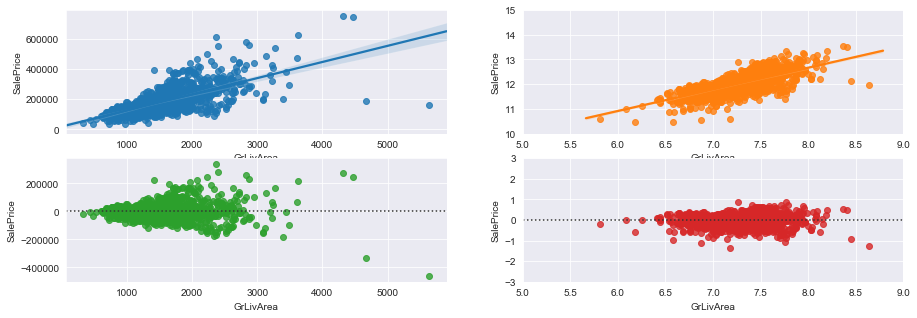

In [80]:
# homoscedasticity after log transformation : GrLivArea
fig, ax = plt.subplots(2,2, figsize=(15,5))
dat = train.copy()
dat['SalePrice'] = np.log1p(dat['SalePrice'])
dat['GrLivArea'] = np.log1p(dat['GrLivArea'])

sns.regplot(data=train, x='GrLivArea', y='SalePrice', ax=ax[0][0])
sns.regplot(data=dat, x='GrLivArea', y='SalePrice', ax=ax[0][1])
ax[0][1].set_xlim(5,9)
ax[0][1].set_ylim(10,15)

sns.residplot(data=train, x='GrLivArea', y='SalePrice', ax=ax[1][0])
sns.residplot(data=dat, x='GrLivArea', y='SalePrice', ax=ax[1][1])
ax[1][1].set_xlim(5,9)
ax[1][1].set_ylim(-3,3)

plt.show()

C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


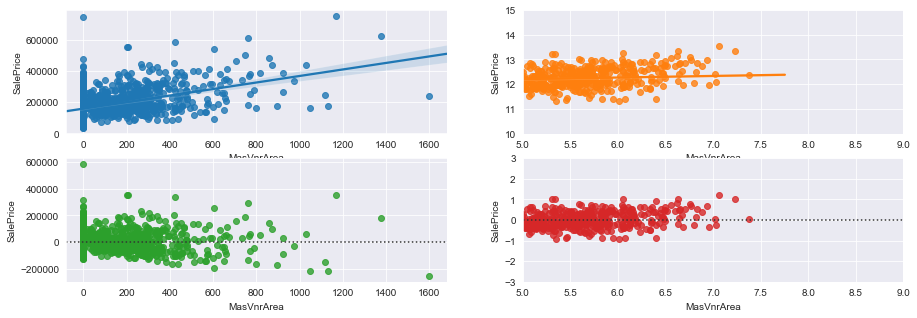

In [81]:
# homoscedasticity after log transformation : MasVnrArea
fig, ax = plt.subplots(2,2, figsize=(15,5))
dat = train.copy()
dat['SalePrice'] = np.log1p(dat['SalePrice'])
dat['MasVnrArea'] = np.log1p(dat['MasVnrArea'])

sns.regplot(data=train, x='MasVnrArea', y='SalePrice', ax=ax[0][0])
sns.regplot(data=dat, x='MasVnrArea', y='SalePrice', ax=ax[0][1])
ax[0][1].set_xlim(5,9)
ax[0][1].set_ylim(10,15)

sns.residplot(data=train, x='MasVnrArea', y='SalePrice', ax=ax[1][0])
sns.residplot(data=dat, x='MasVnrArea', y='SalePrice', ax=ax[1][1])
ax[1][1].set_xlim(5,9)
ax[1][1].set_ylim(-3,3)

plt.show()

# Preprocessing

In [85]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

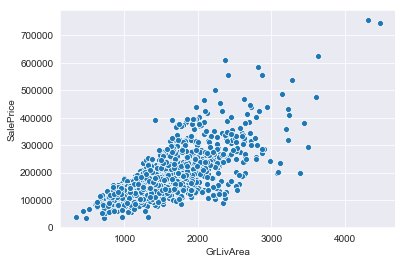

In [86]:
# Removing Outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index) # Removing
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice') # After
plt.show()

In [87]:
# Combining 
test['SalePrice'] = 0
data = pd.concat([train,test], axis=0)
data.reset_index(drop=True, inplace=True)

In [88]:
# NA Handling
data['MSZoning'].fillna(data['MSZoning'].mode()[0], inplace=True)

data['Utilities'].fillna(data['Utilities'].mode()[0], inplace=True)
data['Exterior1st'].fillna(data['Exterior1st'].mode()[0], inplace=True)
data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0], inplace=True)
data['MasVnrType'].fillna('None', inplace=True)
data['MasVnrArea'].fillna(0, inplace=True)
data['BsmtQual'].fillna('None', inplace=True)
data['BsmtCond'].fillna('None', inplace=True)
data['BsmtExposure'].fillna('None', inplace=True)
data['BsmtFinType1'].fillna('None', inplace=True)
data['BsmtFinSF1'].fillna(0, inplace=True)
data['BsmtFinType2'].fillna('None', inplace=True)
data['BsmtFinSF2'].fillna(0, inplace=True)
data['BsmtUnfSF'].fillna(0, inplace=True)
data['TotalBsmtSF'].fillna(0, inplace=True)
data['Electrical'].fillna(data['Electrical'].mode()[0], inplace=True)
data['BsmtFullBath'].fillna(0, inplace=True)
data['BsmtHalfBath'].fillna(0, inplace=True)
data['KitchenQual'].fillna(data['KitchenQual'].mode()[0], inplace=True)
data['Functional'].fillna('None', inplace=True)
data['GarageType'].fillna('None', inplace=True)
data['GarageFinish'].fillna('None', inplace=True)
data['GarageYrBlt'].fillna(data['GarageYrBlt'].mode()[0], inplace=True)
data['GarageArea'].fillna(0, inplace=True)
data['GarageCars'].fillna(0, inplace=True)
data['GarageQual'].fillna('None', inplace=True)
data['SaleType'].fillna(data['SaleType'].mode()[0], inplace=True)

data['GarageCond'].fillna('None', inplace=True)
data['PoolQC'].fillna('None', inplace=True)
data['Fence'].fillna('None', inplace=True)
data['MiscFeature'].fillna('None', inplace=True)
data['LotFrontage'].fillna(0, inplace=True)
data['Alley'].fillna('None', inplace=True)
data['FireplaceQu'].fillna('None', inplace=True)

In [89]:
# Dropping columns with too many NAs
cols = ['MiscFeature', 'Alley', 'PoolQC', 'Fence', 'FireplaceQu', 'GarageCond', 'LotFrontage']
data.drop(cols, axis=1, inplace=True)

In [90]:
# Adding/Revising Columns
    # Num Columns
data['Total_SF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
data['Total_Bath'] = data['BsmtFullBath'] + data['BsmtHalfBath']*0.5 + data['FullBath'] + data['HalfBath']*0.5
data['Total_Footage'] = data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF']
data['Age'] = 2020 - data['YearBuilt']
data['Age_rmd'] = 2020 - data['YearRemodAdd']
data['Age_Garage'] = 3020 - data['GarageYrBlt']
data['qul_grliv'] = data['OverallQual'] * data['GrLivArea']
data['garage'] = data['GarageCars'] * data['GarageArea']
data['Years'] = data['YearBuilt'] + data['YearRemodAdd'] + data['GarageYrBlt']

data['Age_not_rmd'] = data['Age'] - data['Age_rmd']
data['Overall'] = data['OverallQual'] + data['OverallCond']
data['porch'] = data['OpenPorchSF'] + data['EnclosedPorch'] + data['ScreenPorch']


data['haspool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data['has2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
data['hasgarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data['hasbsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data['hasfireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

    # Cat Columns
# data['Ext_Kit'] = data['ExterQual'] + data['KitchenQual']
# data['Bsm_Heat'] = data['BsmtQual'] + data['HeatingQC']
# data['Gara_TP1'] = data['GarageFinish'] + data['BsmtFinType1']
data['Season'] = data['MoSold'].apply(lambda x: 'Spring' if x<= 3 else ('Summer' if x <=6 else ('Fall' if x <=9 else 'Winter')))
data.drop(['MoSold'], axis=1, inplace=True)

In [91]:
# Processing Types of Variables 
to_cat = ['MSSubClass']
data[to_cat] = data[to_cat].astype(str)

In [92]:
# Dividing columsn into num and cat
num_col = []
cat_col = []
for col in data.columns:
    if col == "Id" or col == 'SalePrice':
        continue
    elif data[col].dtype == 'object':
        cat_col.append(col)
    else:
        num_col.append(col)

print(len(num_col))
print(len(cat_col))
print(len(data.columns))

50
39
91


In [93]:
# Label Encoding & Dummy

# labels_col = ['LotShape', 'LandContour', 'LandSlope', 'HouseStyle', 'ExterQual',
#              'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
#              'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional',
#               'GarageFinish', 'GarageQual', 'PavedDrive']

# for col in labels_col:
#     data[col] = pd.factorize(data[col])[0]

# data['LotShape'] = data['LotShape'].apply(lambda x: {'IR3':0, 'IR2':1, 'IR1':2, 'Reg':3}[x])
# data['LandContour'] = data['LandContour'].apply(lambda x: {'Low':0, 'HLS':1, 'Bnk':2, 'Lvl':3}[x])
# data['LandSlope'] = data['LandSlope'].apply(lambda x: {'Gtl':0, 'Mod':1, 'Sev':2}[x])
# data['HouseStyle'] = data['HouseStyle'].apply(lambda x: {'1Story':0, '1.5Unf':1, '1.5Fin':2,
#                                                         '2Story':3, '2.5Unf':4, '2.5Fin':5,
#                                                         'SFoyer':6, 'SLvl':7}[x])
# data['CentralAir'] = data['CentralAir'].apply(lambda x: {'N':0, 'Y':1}[x])
# data['Functional'] = data['Functional'].apply(lambda x: {'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4,
#                                                         'Min2':5, 'Min1':6, 'Typ':7, 'None':-99}[x])
# data['BsmtExposure'] = data['BsmtExposure'].apply(lambda x: {'No':0, 'Mn':1, 'Av':2, 'Gd':3, 'None':-99}[x])
# data['GarageFinish'] = data['GarageFinish'].apply(lambda x: {'Unf':0, 'RFn':1, 'Fin':2, 'None':-99}[x])
# data['PavedDrive'] = data['PavedDrive'].apply(lambda x: {'N':0, 'P':1, 'Y':2}[x])
# for col in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual']:
#     data[col] = data[col].apply(lambda x: {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4, 'None':-99}[x])
# for col in ['BsmtFinType1', 'BsmtFinType2']:
#     data[col] = data[col].apply(lambda x: {'Unf':0, 'LwQ':1, 'Rec':2, 'BLQ':3, 'ALQ':4, 'GLQ':5,'None':-99}[x])


for col in cat_col:
# for col in list(set(cat_col) - set(labels_col)):
    data = pd.concat([data,pd.get_dummies(data[col], prefix=(col))], axis=1)
    data.drop([col], axis=1, inplace=True)

In [94]:
# Solving Skew Problem
skews = []
for col in num_col:
    skews.append((col, skew(data[col])))
skews.sort(key=lambda x : -abs(x[1]))

for col, value in skews:
    if abs(value) >0.5:
        data[col] = boxcox1p(data[col], 0.15) # boxcox
        
data['SalePrice'] = np.log1p(data['SalePrice']) # log(x+1)

In [95]:
### Dropping columns that have high corr with other vars 
cols = ['GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd', '2ndFlrSF', 'BsmtFullBath']
data.drop(cols, axis=1, inplace=True)

num_col = list(set(num_col)-set(cols))

In [96]:
# Dropping Sparse Columns
cols = []
for col in data.columns:
    major_ratio = data[col].value_counts().iloc[0]/len(data[col])
    if major_ratio > 0.999:
        cols.append(col)

data.drop(cols, axis=1, inplace=True)
print('# of columns dropped : {}'.format (len(cols)))

# of columns dropped : 19


In [97]:
# PCA ! 
# pca = PCA()
# # data[num_col] = pca.fit_transform(data[num_col])
# data[num_col[:4]] = pca.fit_transform(data[num_col])[:,:4]
# data.drop(num_col[4:], axis=1, inplace=True)

In [98]:
data.shape

(2917, 285)

In [99]:
# Dividing
data.reset_index(drop=True, inplace=True)
train = data[data['Id']<=1460]
test = data[data['Id'] >1460]

X = list(set(train.columns) - set(['SalePrice']))
y = 'SalePrice'

### Baseline Models

In [100]:
def rmse_cv(model):
    result = cross_val_score(cv=5, estimator=model, X=train[X].values, y=train[y].values, scoring='neg_mean_squared_error')
    result = (-result)**(1/2)
    return np.mean(result), np.std(result)

#  Scoring Options of 'cross_val_score' function:
    # 'accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 'explained_variance', 
    # 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 
    # 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error',
    # 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2',
    # 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score'

In [101]:
def rmsle(pred, actual):
    result = 0
    for i in range(len(pred)):
        result += (pred[i] - actual[i])**2
    result /= len(pred)
    return result**(1/2)

In [102]:
EN = make_pipeline(RobustScaler(), ElasticNet(alpha=1e-3, l1_ratio=0.7, max_iter=1e+4)) 
rmse_cv(EN)

# Objective Function of ElasticNet
    # 1 / (2 * n_samples) * ||y - Xw||^2_2
    # + alpha * l1_ratio * ||w||_1
    # + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

(0.10898620490590474, 0.006421955695899211)

In [103]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=5e-04, max_iter=1e+04))
rmse_cv(lasso)

(0.10831737794787903, 0.006342639758559387)

In [104]:
KRR = KernelRidge(alpha=1e-2, kernel='polynomial', degree=1, coef0=2) # kernel: 'linear', 'laplacian', 'rbf'
rmse_cv(KRR)

(0.11216813028214519, 0.007625876456613576)

In [105]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=30, min_samples_split=10, 
                                   loss='huber', random_state =5)
rmse_cv(GBoost) # shows low performance when I keep high-cor variables

(0.11576786066213467, 0.009656194376123984)

In [106]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.3, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.3, n_estimators=1024,
                             reg_alpha=0.3, reg_lambda=0.4,
                             subsample=0.5, silent=1,
                             random_state =7, nthread = -1)
rmse_cv(model_xgb)

(0.11344205435188899, 0.0061305957669310724)

In [107]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=4,
                              learning_rate=0.05, n_estimators=1024,
                              max_bin = 40, bagging_fraction = 0.9,
                              bagging_freq = 20, feature_fraction = 0.1, #W 0.6 > 0.2 로 낮추니 엄청난효과!
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf = 2, min_sum_hessian_in_leaf = 1, random_state=5)
rmse_cv(model_lgb)

(0.11106738823664011, 0.007518130377026073)

In [109]:
def baseline_model():
    model = Sequential()
    model.add(Dense(64, input_dim=len(X), kernel_initializer='normal', activation='relu'))
#     model.add(BatchNormalization())
    model.add(Dense(8, input_dim=64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    opt = optimizers.Adam(lr = 0.005)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

nn = KerasRegressor(build_fn=baseline_model, epochs=3000, batch_size=len(train), verbose=0)
rmse_cv(nn)

(0.1333776960655107, 0.013410510304401563)

### Weighted Ensemble with Meta Regressor

In [114]:
class Meta_Regressor(BaseEstimator):
    def __init__(self, base_models, meta_models):
        self.base_models = base_models # self.A = B 에서 A와 B가 이름이 같아야한다.. 뭐지 
        self.meta_models = meta_models
        
    def fit(self, X, y):
        self.base_models_ = [[] for _ in self.base_models]
        self.meta_models_ = clone(self.meta_models)
        
        Kf = KFold(n_splits=5, shuffle=True, random_state=5)
        out_fold_pred = np.zeros((len(X), len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_idx, val_idx in Kf.split(X):
                model = clone(self.base_models[i])
                model.fit(X[train_idx], y[train_idx])
                pred = model.predict(X[val_idx])
                out_fold_pred[val_idx, i] = pred
                self.base_models_[i].append(model)
                
        self.meta_models_.fit(X=out_fold_pred, y=y)
                  
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in sub_models]).mean(axis=1)
        for sub_models in self.base_models_])
        
        scores = self.meta_models_.predict(meta_features)
        return scores

In [115]:
class Weighted_Ensemble(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(model) for model in self.models]
        for model in self.models_:
            model.fit(X, y)
            
    def predict(self, x):
        results = np.zeros(len(x))
        scores = [model.predict(x) for model in self.models_]
#         for i, model in enumerate(scores):
#             results += scores[i] * self.weights[i]
        return scores

In [116]:
meta_regressor = Meta_Regressor(base_models= [lasso, KRR, GBoost, model_xgb, model_lgb, nn], meta_models = EN)
weighted_ensemble = Weighted_Ensemble(models= [lasso, KRR, GBoost, model_xgb, model_lgb, nn, EN, meta_regressor])

train_x, test_x, train_y, test_y = train_test_split(train[X].values, train[y].values, test_size=0.3, random_state=4)
weighted_ensemble.fit(train_x, train_y)
scores = weighted_ensemble.predict(test_x)

In [161]:
weights = [0.09, 0.15, 0.24, 0.01, 0.15, 0.01, 0.3, 0.05] # Finding Optimized weight values
      # lasso, KRR, GBoost, xgb, lgb,  nn,   EN, meta
    
score = np.zeros(len(scores[0]))
for i, model in enumerate(scores):
    score += scores[i] * weights[i]
rmsle(score, test_y)

0.0993441400918558

### Final Prediction

In [162]:
# meta_ensemble
weighted_ensemble.fit(train[X].values, train[y].values)
scores = weighted_ensemble.predict(test[X].values)
score = np.zeros(len(scores[0]))
for i, model in enumerate(scores):
    score += scores[i] * weights[i]
pred = np.expm1(score)

In [163]:
submission = pd.DataFrame({
    'Id': range(1461, 2920),
    'SalePrice': pred
})

submission.to_csv("submission.csv", index=False) # 0.11528 (505/5025 as of 2 Feb)